# Results Analysis

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 27 November 2025 *(but `02_eda.ipynb` started sooner)  
Last updated: 30 November 2025

In [2]:
"""
Module providing supporting code and generating all images/tables for results analysis. Some code from 02_eda.ipynb.
"""

'\nModule providing supporting code and generating all images/tables for results analysis. Some code from 02_eda.ipynb.\n'

## Setup

### Packages

In [3]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For time series data management
# import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as dt

# For data importing
from helper_utils import get_path, apply_model

from sklearn.metrics import PrecisionRecallDisplay

In [4]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

### Load data

In [5]:
best_threshold = 0.31686868686868686
best_threshold_orig = 0.30696969696969695

best_window = 1
best_window_orig = 29

In [6]:
# Tuning results
oof_tuning = pd.read_parquet(get_path('results/train_oof_wt_tuning.parquet', 'outputs'))

# Dates of test set
y_dates = pd.read_parquet(get_path('results/test_index.parquet', 'outputs'))

# True values
y_true = np.load(get_path('results/test_y_true.npy', 'outputs'))

# Predicted values
y_pred = np.load(get_path('results/test_y_pred.npy', 'outputs'))

# Predicted probabilities
y_pred_proba = np.load(get_path('results/test_y_pred_proba.npy', 'outputs'))

## W/T Tuning

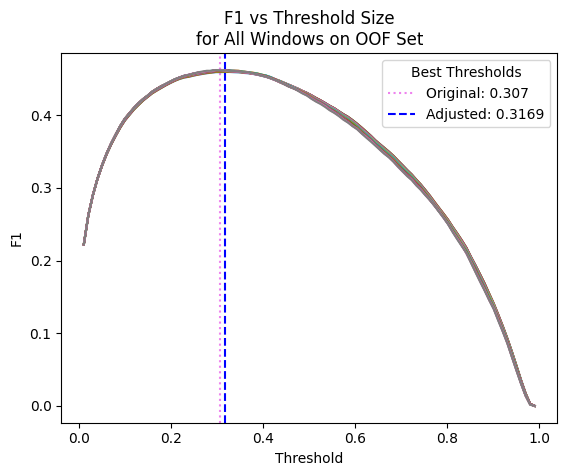

In [7]:
fig, ax = plt.subplots()

wt_tune_results_np = oof_tuning.copy()

# Plot best threshold
ax.axvline(
    x = best_threshold_orig,
    color = 'violet', linestyle = 'dotted',
    # label='orig Best Threshold'
    # label = f'Original params: W{best_window_orig}, T{best_threshold_orig:.4}'
    label = f'Original: {best_threshold_orig:.4}'
    )
# plt.text(
#     best_threshold_orig - 0.03, 0,
#     f'Original threshold {best_threshold_orig:.4} at window {best_window_orig}',
#     # 'Original threhsold: '+ str(round(best_threshold_orig,4)) + ' at window ' str(best_window_orig),
#     rotation=90,
#     color='purple'
#     )
ax.axvline(
    x = best_threshold,
    color = 'blue', linestyle = 'dashed',
    # label='Best Threshold'
    # label = f'Corrected params: W{best_window}, T{best_threshold:.4}'
    label = f'Adjusted: {best_threshold:.4}'
    )
# plt.text(
#     best_threshold + 0.01, 0,
#     f'Best threshold {best_threshold:.4} at window {best_window}',
#     # 'Original threhsold: '+ str(round(best_threshold,4)) + ' at window ' str(best_window),
#     rotation=90,
#     color='red'
#     )

# Plot ea window size test
for name, group in wt_tune_results_np.groupby('window'):
    ax.plot(
        group['threshold'], group['F1'],
        label=None
        )

## Plot labels
ax.set_title('F1 vs Threshold Size\nfor All Windows on OOF Set')
ax.set_xlabel('Threshold')
ax.set_ylabel('F1')
ax.legend(title='Best Thresholds')
# Can remove legend since windows are so close...
# ax.legend().set_visible(False)

plt.savefig(get_path('figures/oof_tune.png', 'outputs'))

plt.show()
del fig, ax, name, group, wt_tune_results_np

## Precision-Recall Curve

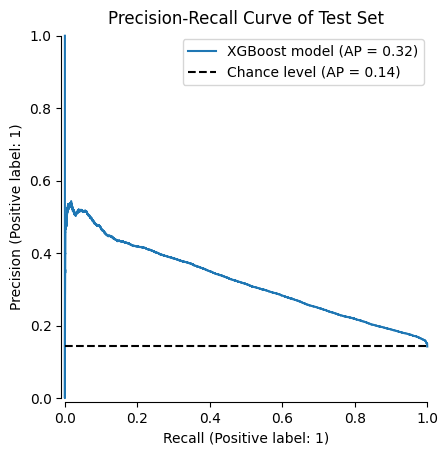

In [8]:
# y_score = classifier.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_true, y_pred_proba,
    name="XGBoost model",
    plot_chance_level=True,
    # Cleanup
    despine=True
)

_ = display.ax_.legend(loc='upper right')
_ = display.ax_.set_title("Precision-Recall Curve of Test Set")
# plt.savefig(get_path('figures/oof_tune.png', 'outputs'))
display.figure_.savefig(get_path('figures/final_prcurve.png', 'outputs'))
del display

## Performance time series

In [9]:
y_comp = pd.DataFrame()
y_comp['timestamp'] = y_dates.copy()
y_comp['y_pred'] = y_pred.copy()
y_comp['y_true'] = y_true.copy()
y_comp['y_match'] = (y_comp['y_pred'] == y_comp['y_true'])
y_comp = y_comp.drop('timestamp', axis=1)
y_comp

,y_pred,y_true,y_match
2018-03-08 21:55:00,1,0.0,False
2018-03-08 22:00:00,1,0.0,False
2018-03-08 22:05:00,1,0.0,False
2018-03-08 22:10:00,1,0.0,False
2018-03-08 22:15:00,1,0.0,False
...,...,...,...
2025-08-01 12:40:00,0,0.0,True
2025-08-01 12:45:00,0,0.0,True
2025-08-01 12:50:00,0,0.0,True
2025-08-01 12:55:00,0,0.0,True


In [10]:
y_comp_sumstats = y_comp.copy()['y_match']
y_comp_sumstats = y_comp_sumstats.resample('1ME').agg(['count', 'sum'])
y_comp_sumstats['per'] = (y_comp_sumstats['sum']/y_comp_sumstats['count'])*100
y_comp_sumstats
# y_comp_sumstats = y_comp_sumstats.resample('1ME').agg(['mean','std'])
# ax2.plot(soil_subset.index, soil_subset['h2o_by_wet_shallow']['mean'], label="Shallow SM", color='violet')
# ax2.plot(soil_subset.index, soil_subset['h2o_by_wet_deep']['mean'], label="Deep SM", color='purple')

,count,sum,per
2018-03-31,6649,3286,49.420966
2018-04-30,8640,1566,18.125000
2018-05-31,8928,4777,53.505824
2018-06-30,8640,7428,85.972222
2018-07-31,8928,3548,39.740143
...,...,...,...
2025-04-30,8640,7287,84.340278
2025-05-31,8928,3583,40.132168
2025-06-30,8640,4606,53.310185
2025-07-31,8921,4860,54.478198


In [11]:
y_comp_blockages = y_comp.copy()
y_comp_blockages = y_comp_blockages[y_comp_blockages['y_true'] == 1]
y_comp_blockages = y_comp_blockages.resample('1ME').count()
y_comp_blockages['count'] = y_comp_sumstats.copy()['count']
# y_comp_blockages = y_comp_blockages['y_true']
y_comp_blockages['per'] = (y_comp_blockages['y_true']/y_comp_blockages['count'])*100
y_comp_blockages = y_comp_blockages.drop(['y_pred', 'y_match'], axis=1)
y_comp_blockages

,y_true,count,per
2018-03-31,668,6649,10.046624
2018-04-30,0,8640,0.000000
2018-05-31,1815,8928,20.329301
2018-06-30,594,8640,6.875000
2018-07-31,24,8928,0.268817
...,...,...,...
2025-03-31,2032,8928,22.759857
2025-04-30,163,8640,1.886574
2025-05-31,2442,8928,27.352151
2025-06-30,979,8640,11.331019


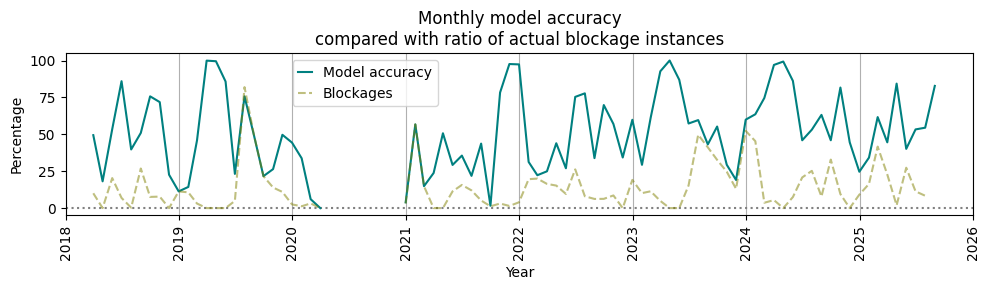

In [13]:
#Running avg plot

fig, ax = plt.subplots(figsize=(10, 3))
## Line for 0
plt.axhline(y=0, color = "grey", linestyle = ":")
# Mean
ax.plot(y_comp_sumstats.index, y_comp_sumstats['per'], color='teal', label="Model accuracy")
ax.plot(y_comp_blockages.index, y_comp_blockages['per'], color = 'olive', linestyle="dashed", alpha=0.5, label="Blockages")
# ax.plot(data_sumstats.index, data_sumstats['mean'], color = 'green', label = "Mean")
# Ribbon for standard deviation
# ax.fill_between(data_sumstats.index, data_sumstats['mean']-data_sumstats['std'], data_sumstats['mean']+data_sumstats['std'], color = 'aquamarine', label = "std")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.set_title("Monthly model accuracy\ncompared with ratio of actual blockage instances")
# ax.set_ylim(bottom = 0)
# ax.set_xlim(left = dt.date(1989, 1, 1), right = dt.date(2026, 1, 1))
# ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
# plt.xticks(rotation = 90)
# plt.tight_layout()
# plt.grid(axis = 'x', which = 'major')
plt.legend(loc = 'upper center', handlelength=1, bbox_to_anchor=(0.33,1))
ax.set_xlim(left = dt.date(2018, 1, 1), right = dt.date(2026, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(month = 1)) # Show ticks at start of year
plt.xticks(rotation = 90)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.grid(axis = 'x', which = 'major')
# Truncate plot
# ax.set_ylim(bottom = 0, top = 250)

plt.savefig(get_path('figures/ts_accuracy.png', 'outputs'))

plt.show()

del fig, ax

## Samples

In [15]:
y_comp

,y_pred,y_true,y_match
2018-03-08 21:55:00,1,0.0,False
2018-03-08 22:00:00,1,0.0,False
2018-03-08 22:05:00,1,0.0,False
2018-03-08 22:10:00,1,0.0,False
2018-03-08 22:15:00,1,0.0,False
...,...,...,...
2025-08-01 12:40:00,0,0.0,True
2025-08-01 12:45:00,0,0.0,True
2025-08-01 12:50:00,0,0.0,True
2025-08-01 12:55:00,0,0.0,True


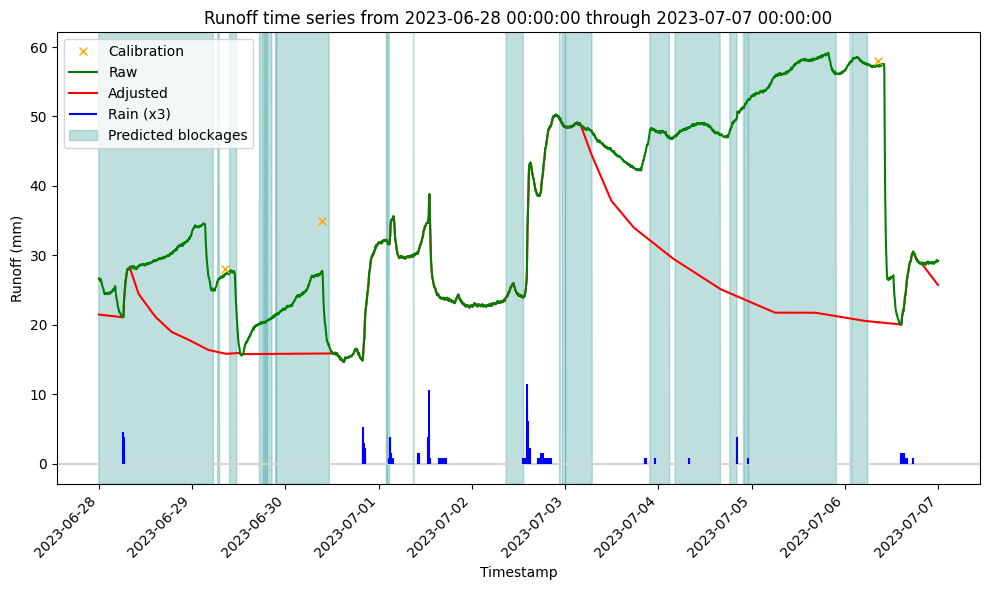

In [38]:
# from 02_eda.ipynb
data_water = pd.read_parquet(get_path('clean/water.parquet'))

input_date_start = '2023-06-28 00:00:00'
input_date_end = '2023-07-07 00:00:00'

# Filter the data sets
data_subset = data_water[input_date_start:input_date_end].copy()
data_subset = data_subset.join(y_comp[input_date_start:input_date_end])

fig, ax = plt.subplots(figsize=(10, 6))

plt.axhline(y = 0, color ='lightgrey')

# y_comp_subset = y_comp[input_date_start:input_date_end].copy()
# for i (date, is_true) in enumerate(zip(y_comp_subset.index, y_comp_subset[y_pred])):
#     if is_true:
#             ax.axvspan(date, date + datetime.timedelta(days=1), color='grey', alpha=0.3)
ax.fill_between(
    data_subset.index,
    0,
    1,
    # data_subset['level_ro'],
    where=(data_subset['y_pred']==1),
    color = 'teal',
    alpha=0.25,
    transform=ax.get_xaxis_transform(),
    label="Predicted blockages",
    interpolate=True
    )


# Rain
ax.vlines(
    data_subset.index,
    ymin = 0,
    ymax = data_subset['ra_rain']*3,
    color = 'blue',
    label = 'Rain (x3)'
)

# Adjusted RO values
ax.plot(
    data_subset.index,
    data_subset['level_ro'],
    color = 'red',
    label = "Adjusted"
)

# Plot raw runoff values
ax.plot(
    data_subset.index,
    data_subset['raw_ro'],
    color = 'green',
    label = "Raw"
)

# Plot calibration points
ax.plot(
    data_subset.index,
    data_subset['weir_level_cal'],
    linestyle = 'none',
    marker = 'x',
    color = 'orange',
    label = "Calibration"
)

# Plot labels and settings
ax.set_ylabel("Runoff (mm)")
ax.set_xlabel("Timestamp")
ax.set_title(f"Runoff time series from {data_subset.index.min()} through {data_subset.index.max()}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Reverse the order of the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.savefig(get_path('figures/preformance_ex.png', 'outputs'))
plt.show()


del data_water, data_subset, input_date_start, input_date_end, fig, ax, handles, labels

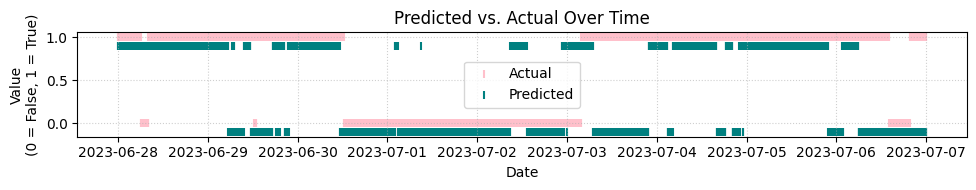

In [48]:
# start_date = None
# end_date = None

# start_date = '2018-01-01 00:00:00'
# end_date = '2020-05-01 00:00:00'
start_date = '2023-06-28 00:00:00'
end_date = '2023-07-07 00:00:00'

comp = y_dates.copy()
comp['true'] = y_true
comp['pred'] = y_pred
comp = comp.drop(0, axis=1)

comp = comp[start_date:end_date]
# comp.head()

# 2. Visualize the data
# fig, ax = plt.figure(figsize=(15, 2))
fig, ax = plt.subplots(figsize=(10, 2))

# Plot the predicted probability as a line
ax.scatter(comp.index, comp['pred']-0.1, label='Predicted', color='teal', marker='|')

# Plot the actual truth values as discrete points
# Using a scatter plot on the same y-axis range (0 or 1)
ax.scatter(comp.index, comp['true'], label='Actual', color='pink', marker='|')

# # Optional: Add a threshold line to show where predictions turn to True/False
# threshold = 0.5
# plt.axhline(y=threshold, color='gray', linestyle='--', label=f'Threshold ({threshold})')

# 3. Enhance the plot
plt.title('Predicted vs. Actual Over Time')
plt.xlabel('Date')
plt.ylabel('Value\n(0 = False, 1 = True)')
# plt.ylim(-0.1, 1.1) # Set y-limits to clearly show 0 and 1


# plt.legend(loc='center')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center')

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.savefig(get_path('figures/preformance_ex_flag.png', 'outputs'))
# Display the plot
plt.show()

del comp, start_date, end_date


## drafting

Feature importance

In [50]:
import joblib

final_model = joblib.load(get_path('models/final_full_mod_fitted.joblib', 'outputs'))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pickle.py:1760: UserWarning: [16:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:377: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  setstate(state)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pickle.py:1760: UserWarning: [16:11:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  setstate(state)


In [ ]:
feature_importances = final_model.feature_importances_
# map scores to feature names
# feature_importances
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({
    'feat': feature_names,
    'importance': feature_importances
})

# sort importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# print(feature_importance_df)
feature_importance_df

# most important features
# print(feature_importance_df.head(25))

In [ ]:
# Replace NAs in rain with 0
data_water['ra_rain'] = data_water['ra_rain'].fillna(0)

# Apply decay function
data_water = decay_feat(data_water, 'eventsum_ra_rain')

# Drop extra column
# minutes since rain event will be the same as minutes since most recent rain
data_water = data_water.drop('minsince_eventsum_ra_rain', axis=1)

In [ ]:
threshold_importance = 0.95
# calculate most important 90 percent of the importance
feature_importance_df['cumulative_imp'] = feature_importance_df['importance'].cumsum()
features_percent = feature_importance_df[feature_importance_df['cumulative_imp'] <= threshold_importance].shape[0] + 1
features_percent

In [ ]:
# Most important features:
print(round(threshold_importance*100), "% (most important features):", features_percent)
feature_importance_df.head(features_percent)

In [ ]:
# feature_importance_df.tail(1)
# Least important features:
print("Remaining", round((1-threshold_importance)*100), "% (least important features):", len(feature_names)-features_percent)
feature_importance_df.tail(len(feature_names)-features_percent)

In [ ]:
# Features with 0 importance:
print("Features with 0 importance:", len(feature_importance_df[feature_importance_df['importance']==0]))

feature_importance_df[feature_importance_df['importance']==0]

feature importance by type

In [ ]:
mapping_dict = {
    'soil': '_deep|_shallow',
    'runoff':'ro',
    'rain':'rain',
    'calibration':'_cal'
}

for col_name, pattern in mapping_dict.items():
    feature_importance_df[col_name] = feature_importance_df['feat'].str.contains(pattern, case=False, regex=True)

feature_importance_df

In [ ]:
feature_importance_df['most'] = (feature_importance_df['cumulative_imp'] <= threshold_importance)
feature_importance_df['zero'] = (feature_importance_df['importance'] == 0)

cat_cols = list(mapping_dict.keys())

table_feature_cat_importance = pd.DataFrame({
    'Total features': feature_importance_df[cat_cols].sum(),
    'Above threshold': feature_importance_df[feature_importance_df['most']][cat_cols].sum(),
    'Below threshold': feature_importance_df[~feature_importance_df['most']][cat_cols].sum(),
    'Zero importance': feature_importance_df[feature_importance_df['zero']][cat_cols].sum()
}).fillna(0).astype(int)

del cat_cols, mapping_dict

table_feature_cat_importance.index.name = 'Category'

table_feature_cat_importance